In [3]:
# import cudf
# from cuml import RandomForestClassifier as cuRF
from collections import defaultdict
import gensim
import html
from itertools import islice
import json
import matplotlib.pyplot as plt
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer 

import numpy as np
import operator
import pandas as pd
import pickle
import re
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

import seaborn as sns
import string

from IPython.display import display, HTML

DistributionNotFound: The 'pyasn1-modules>=0.2.1' distribution was not found and is required by google-auth

In [2]:
HASHTAG_REGEXP = "#\w+"
LINK_REGEXP = r"https?://[\w./-]+"
HANDLE_REGEXP = "@\S+"
STOPWORDS = stopwords.words('english')

NameError: name 'stopwords' is not defined

In [266]:
with open("./contractions.json", 'r') as f:
    CONTRACTIONS_DICT = json.load(f)

In [5]:
def clean_location(row, location_col='location'):
    if row[location_col] is np.nan or not row[location_col].strip().replace("\'|#|@", ""):
        return "N/A"
    ret_val = re.sub("\W+", ' ', row[location_col].lower())
    ret_val = re.sub("[\s\d]+", ' ', ret_val.strip()).strip()
    if len(ret_val) == 0:
        return "N/A"
    else:
        return ret_val

def lemmatize_sentence(text, tokenizer, lemmatizer):
    tokens_pos_tag = pos_tag(tokenizer.tokenize(text))
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }
    tokens_wordnet = [
        (word, tag_dict.get(pos[0], wordnet.NOUN)) for word, pos in tokens_pos_tag
    ]
    lem_tokens = [lemmatizer.lemmatize(word, pos) for word, pos in tokens_wordnet]
    return lem_tokens

In [6]:
def add_features(df, tokenizer, lemmatizer, text_col="text", keyword_col="keyword"):
    ret_df = df.copy()
    return ret_df.assign(
        keyword=lambda x: ret_df[keyword_col].fillna("N/A"),
        hashtag_in_text=ret_df[text_col].str.contains(HASHTAG_REGEXP),
        hashtags=ret_df[text_col].apply(lambda x: re.findall(HASHTAG_REGEXP, x)),
        link_in_text=ret_df[text_col].str.contains(LINK_REGEXP),
        links=ret_df[text_col].apply(lambda x: re.findall(LINK_REGEXP, x)),
        mention_in_text=ret_df[text_col].str.contains(HANDLE_REGEXP),
        mentions=ret_df[text_col].apply(lambda x: re.findall(HANDLE_REGEXP, x)),
        location=ret_df.apply(clean_location, location_col="location", axis=1),
        tokens=ret_df[text_col].apply(tokenizer.tokenize),
        lem_tokens=ret_df[text_col].apply(
            lemmatize_sentence, tokenizer=tokenizer, lemmatizer=lemmatizer
        ),
        lem_text=lambda x: x["lem_tokens"].apply(" ".join),
        word_count=lambda x: x["tokens"].apply(len),
        unique_tokens=lambda x: x["tokens"].apply(set),
        unique_word_count=lambda x: x["unique_tokens"].apply(len),
        stop_word_count=lambda x: x["tokens"].apply(
            lambda y: len([token for token in y if token in STOPWORDS])
        ),
        link_count=lambda x: x["links"].apply(len),
        hashtag_count=lambda x: x["hashtags"].apply(len),
        mention_count=lambda x: x["mentions"].apply(len),
        char_count=lambda x: x["tokens"].apply(
            lambda y: np.sum([len(token) for token in y])
        ),
        mean_word_length=lambda x: x["char_count"] / x["word_count"],
        punctuation_count=lambda x: x["tokens"].apply(
            lambda y: len([token for token in y if token in string.punctuation])
        ),
    )


def reduce_locations(df, location_col="location", id_col="id"):
    # Handle location categories that only appear a single time by replacing them with N/A
    ret_df = df.copy()

    single_location_list = (
        ret_df.groupby(location_col, as_index=False)
        .agg({id_col: "count"})
        .rename(columns={id_col: "row_count"})
        .query("row_count == 1")[location_col]
        .tolist()
    )

    return ret_df.assign(
        location=ret_df[location_col].where(
            ~ret_df[location_col].isin(single_location_list), other="N/A"
        )
    )

In [7]:
wnl = WordNetLemmatizer()
tknzr = TweetTokenizer(reduce_len=True)

train_df = (pd.read_csv("./train.csv")
           .pipe(add_features, tokenizer=tknzr, lemmatizer=wnl)
           .pipe(reduce_locations))

### Features to Add
- word_count number of words in text
- unique_word_count number of unique words in text
- stop_word_count number of stop words in text
- url_count number of urls in text
- mean_word_length average character count in words
- char_count number of characters in text
- punctuation_count number of punctuations in text
- hashtag_count number of hashtags (#) in text
- mention_count number of mentions (@) in text

In [8]:
# Plot the distributions for the new features
features_to_plot = ['word_count', 'unique_word_count', 'stop_word_count', 'link_count', 'hashtag_count',
                    'mention_count', 'char_count', 'mean_word_length', 'punctuation_count']

In [17]:
#g = sns.FacetGrid(data=temp_df, row='variable', hue='target', aspect=2, sharex=False, sharey=False)
#g.map(sns.distplot, 'value', label=['1', '0'] )

In [28]:
train_df.loc[~temp_series]['hashtag_count'].describe()

count    4342.000000
mean        0.388761
std         1.002390
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.000000
Name: hashtag_count, dtype: float64

Plotting word_count
Plotting unique_word_count
Plotting stop_word_count
Plotting link_count
Plotting hashtag_count
Plotting mention_count
Plotting char_count
Plotting mean_word_length
Plotting punctuation_count


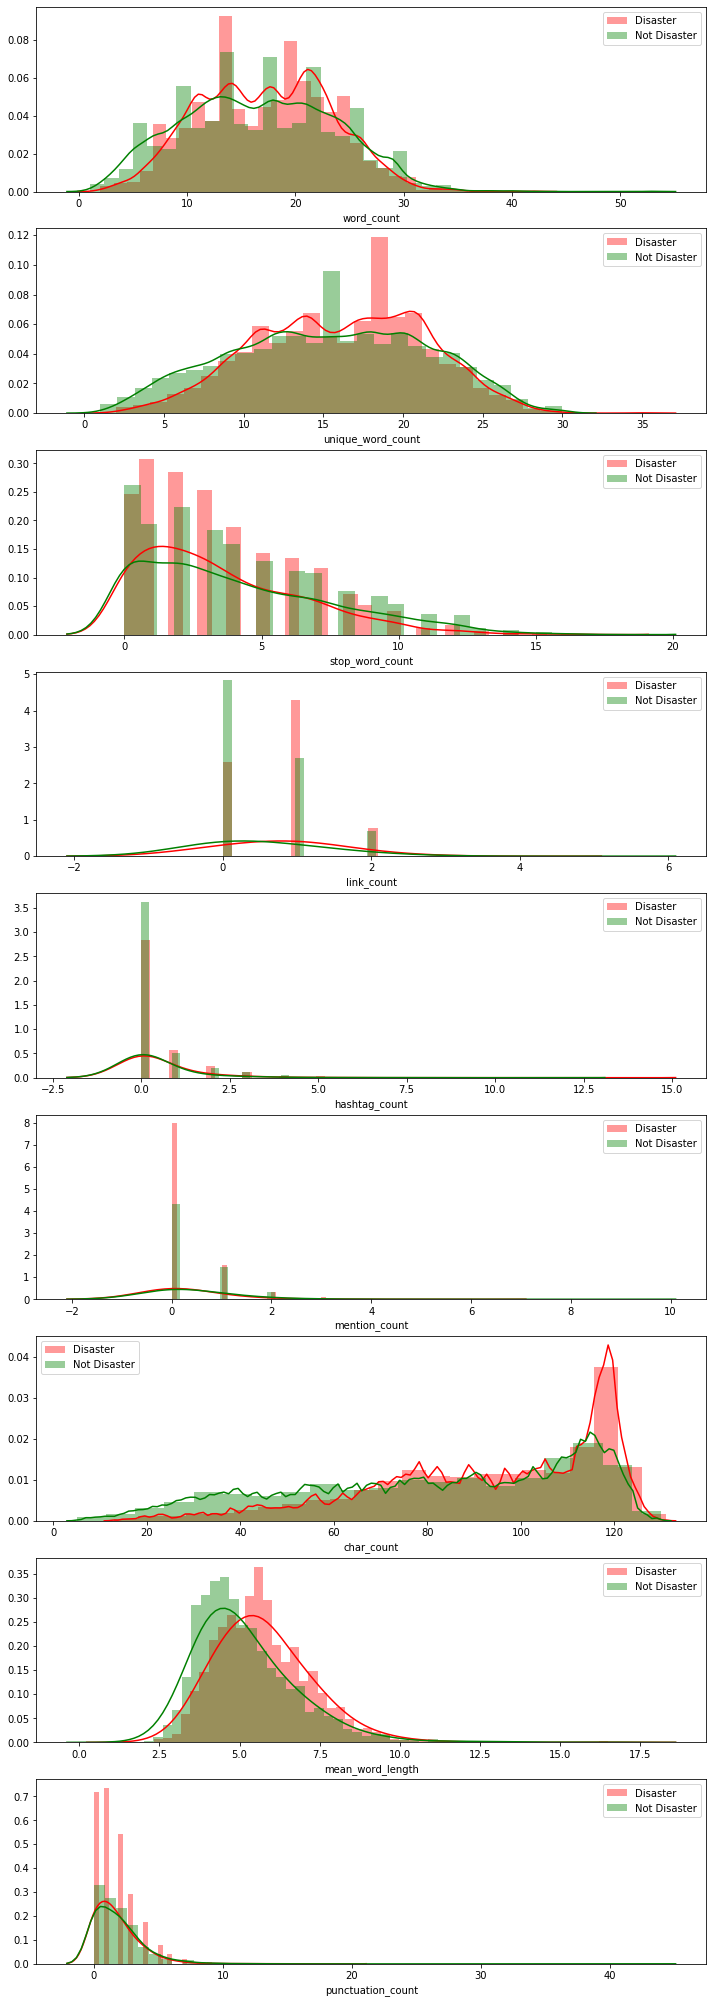

In [25]:
fig, axes = plt.subplots(nrows=len(features_to_plot), figsize=(12, 4*len(features_to_plot)))
disaster_series = train_df['target'] == 1

for feature, ax in zip(features_to_plot, axes.ravel()):
    print(f"Plotting {feature}")
    sns.distplot(train_df.loc[disaster_series][feature], ax=ax, label='Disaster',
                 color='red', kde_kws={'bw': 0.7})
    sns.distplot(train_df.loc[~disaster_series][feature], ax=ax, label='Not Disaster',
                 color='green', kde_kws={'bw': 0.7})
    ax.legend()

In [13]:
from nltk.util import ngrams

In [10]:
from collections import Counter

In [26]:
import nltk
nltk.download('punkt', force=True)

[nltk_data] Downloading package punkt to /home/sjustice/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
from itertools import chain
import string

In [57]:
punct_list = list(string.punctuation)

In [76]:
disaster_text = ' '.join([token for token in train_df.query('target == 1')['text'].str.lower().tolist()
                          if token not in STOPWORDS and token not in punct_list] )

In [74]:
nondisaster_text = ' '.join(train_df.query('target == 0')['text'].tolist())

In [4]:
# from nltk.tag import StanfordNERTagger, StanfordPOSTagger

- Function to take the sentence and output the lemmatized list
    - Input is text
    - Next tokenize and get pos_tag
    - Use the pos_tage with token as input to the lemmatizer
    

In [8]:
from nltk.parse import CoreNLPParser

In [11]:
parser = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

- Convert text to ASCII and ignore errors
- Use htmlParse to remove tags
- Remove urls (maybe mentions as well)
- Replace contractions
- Replace CamelCase
### Done

In [272]:
def clean_text(text):
    # Remove unicode characters
    text = text.encode('ascii', errors='ignore').decode('ascii')
    # Remove urls
    text = html.unescape(text)
    if "http" in text:
        text = re.sub("http[:\/.\w]+", "", text)
        
    text = re.sub("\.{2,}|[:;\-*+\[\]\(\)]|(?<=\W)'|'(?=\W)|^'|'$", " ", text)
    # Replace Underscore with space
    # text = text.replace("_", " ")
    # Replace CamelCase
    match = re.search("[#@]?[A-Z]+[a-z]+[A-Z]\w+", text)
    if match and not match.group(0).startswith('@') and match.group(0) != 'YouTube':
        orig_string = match.group(0)
        match_string = orig_string.replace('#', '')
        replace_array = []
        while re.search('[A-Z]+[a-z]+[A-Z]\w+', match_string):
            replace_array.append(re.search('[A-Z]+[a-z]+', match_string).group(0))
            match_string = re.sub(replace_array[-1], '', match_string, count=1)
        replace_array.append(match_string)
        text = re.sub(orig_string, ' '.join(replace_array), text)

    # Replace contractions
    for pattern, sub in CONTRACTIONS_DICT.items():
        if pattern.lower() in text.lower():
            text = re.sub(pattern, sub, text, flags=re.IGNORECASE)
    return text

In [273]:
clean_train_df = train_df.assign(clean_text=train_df['text'].apply(clean_text))

In [240]:
def count_words(text, word_dict):
    for word in [x for x in re.split("[\s.?_!]", text) if x not in string.punctuation]:
        word_dict[word] += 1

In [32]:
word_dict = defaultdict(int)
_ = clean_train_df['text'].apply(count_words, word_dict=word_dict)

0       None
1       None
2       None
3       None
4       None
        ... 
7608    None
7609    None
7610    None
7611    None
7612    None
Name: text, Length: 7613, dtype: object

In [55]:
with open("./glove-840B-300d.pkl", "rb") as f:
    glove_embeddings = pickle.load(f)

# with open("./crawl-300d-2M.pkl", "rb") as f:
#     fasttex_embeddings = pickle.load(f)

In [56]:
with open("./crawl-300d-2M.pkl", "rb") as f:
    fasttext_embeddings = pickle.load(f)

In [58]:
import gc
# del(fasttex_embeddings)
gc.collect()

2001466

In [73]:
def get_text_vocab_coverage(input_dict, embeddings, embedding_label):
    covered_vocab = dict()
    n_covered = 0
    oov = dict()
    n_oov = 0
    for word, word_count in input_dict.items():
        if word in embeddings:
            covered_vocab[word] = embeddings[word]
            n_covered += word_count
        else:
            oov[word] = word_count
            n_oov += word_count
    
    print(f"Word coverage for {embedding_label} embeddings {len(covered_vocab.keys())/len(input_dict.keys()) * 100:0.2f}%")
    print(f"Text coverage for {embedding_label} embeddings {n_covered/(n_covered + n_oov) * 100:0.2f}%")

    return sorted(oov.items(), key=operator.itemgetter(1))[::-1]

In [49]:
get_text_vocab_coverage(input_dict=word_dict, embeddings=glove_embeddings, embedding_label='Glove')
get_text_vocab_coverage(input_dict=word_dict, embeddings=fasttext_embeddings, embedding_label='FastText')

Word coverage for Glove embeddings 52.03%
Text coverage for Glove embeddings 82.49%
Word coverage for FastText embeddings 51.49%
Text coverage for FastText embeddings 81.64%


In [274]:
clean_word_dict = defaultdict(int)
_ = clean_train_df['clean_text'].apply(count_words, word_dict=clean_word_dict)

In [275]:
glove_oov = get_text_vocab_coverage(input_dict=clean_word_dict, embeddings=glove_embeddings, embedding_label='Glove')
fasttext_oov = get_text_vocab_coverage(input_dict=clean_word_dict, embeddings=fasttext_embeddings, embedding_label='FastText')

Word coverage for Glove embeddings 78.30%
Text coverage for Glove embeddings 94.46%
Word coverage for FastText embeddings 75.01%
Text coverage for FastText embeddings 93.18%


In [284]:
clean_train_df.head()

,id,keyword,location,text,target,hashtag_in_text,hashtags,link_in_text,links,mention_in_text,...,unique_tokens,unique_word_count,stop_word_count,link_count,hashtag_count,mention_count,char_count,mean_word_length,punctuation_count,clean_text
0,1,N/A,N/A,Our Deeds are the Reason of this #earthquake M...,1,True,[#earthquake],False,[],False,...,"{May, the, Forgive, of, are, all, Deeds, this,...",13,5,0,1,0,57,4.384615,0,Our Deeds are the Reason of this #earthquake M...
1,4,N/A,N/A,Forest fire near La Ronge Sask. Canada,1,False,[],False,[],False,...,"{., Sask, near, Canada, fire, Forest, Ronge, La}",8,0,0,0,0,32,4.000000,1,Forest fire near La Ronge Sask. Canada
2,5,N/A,N/A,All residents asked to 'shelter in place' are ...,1,False,[],False,[],False,...,"{notified, evacuation, by, other, residents, b...",20,9,0,0,0,112,4.480000,3,All residents asked to shelter in place are ...
3,6,N/A,N/A,"13,000 people receive #wildfires evacuation or...",1,True,[#wildfires],False,[],False,...,"{evacuation, in, California, people, orders, r...",8,1,0,1,0,57,7.125000,0,"13,000 people receive #wildfires evacuation or..."
4,7,N/A,N/A,Just got sent this photo from Ruby #Alaska as ...,1,True,"[#Alaska, #wildfires]",False,[],False,...,"{from, Just, as, into, this, #wildfires, got, ...",15,6,0,2,0,72,4.500000,0,Just got sent this photo from Ruby #Alaska as ...


In [287]:
clean_train_df.groupby(['text']).agg({'id': 'count'}).query('id > 1')

,id
text,
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,3
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,6
#KCA #VoteJKT48ID 12News: UPDATE: A family of 3 has been displaced after fired damaged housed near 90th and Osborn. Fire extinguished no iÛ_,2
#Myanmar Displaced #Rohingya at #Sittwe point of no return http://t.co/cgf61fPmR0 #Prison like conditions #genocide IHHen MSF Refugees,2
#Newswatch: 2 vehicles collided at Lock and Lansdowne Sts in #Ptbo. Emerg crews on their way,2
...,...
incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,2
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,2
that exploded &amp; brought about the\nbeginning of universe matches what's\nmentioned in the versethe heaven and Earth\n(thus the universe),2


In [279]:
mislabeled_df

,id,keyword,location,text,target,hashtag_in_text,hashtags,link_in_text,links,mention_in_text,...,unique_tokens,unique_word_count,stop_word_count,link_count,hashtag_count,mention_count,char_count,mean_word_length,punctuation_count,clean_text
text,,,,,,,,,,,,,,,,,,,,,
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,2,2,1,1,2,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!,2,1,2,1,2,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',6,1,2,1,2,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,2,1,2,1,2,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
To fight bioterrorism sir.,4,1,1,1,2,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Back from Seattle Tacoma and Portland. Whirlwind! http://t.co/qwHINBni8e,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Baby elephant dies just days after surviving massacre of his family http://t.co/qzCUT7bVKT,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
BUT I will be uploading these videos ASAP so you guys get to see the new weapon types in action!,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [53]:
import gc
del(glove_embeddings, fasttext_embeddings, word_dict, clean_word_dict)
gc.collect()

4209565

- Open the file to be read. This should create a generator
- Create a pool of four threads
- Perform a split on the line using ' '. The first value in the split will be the key and
- the rest of the string will be the value stored in the dictionary.
- Return that value and store it in the dictionary

In [1]:
def split_vec(line):
    line_split = line.split()
    return (line_split[0], line_split[1:])

In [18]:
import numpy as np

In [19]:
def split_vec_dict(line, vec_dict):
    line_split = line.split()
#     print(f"Assigning value for {line_split[0]}\n")
    vec_dict[line_split[0]] = np.array([float(val) for val in line_split[1:]])

In [4]:
from itertools import islice
dict(islice(vec_dict.items(), 2))

{',': ['-0.0282',
  '-0.0557',
  '-0.0451',
  '-0.0434',
  '0.0712',
  '-0.0855',
  '-0.1085',
  '-0.0561',
  '-0.4523',
  '-0.0202',
  '0.0975',
  '0.1047',
  '0.1962',
  '-0.0693',
  '0.0213',
  '-0.0235',
  '0.1336',
  '-0.0420',
  '-0.0564',
  '-0.0798',
  '0.0424',
  '-0.0409',
  '-0.0536',
  '-0.0252',
  '0.0135',
  '0.0064',
  '0.1235',
  '0.0461',
  '0.0120',
  '-0.0372',
  '0.0650',
  '0.0041',
  '-0.1074',
  '-0.0263',
  '0.1133',
  '-0.0029',
  '0.0671',
  '0.1065',
  '0.0234',
  '-0.0160',
  '0.0070',
  '0.4355',
  '-0.0752',
  '-0.4328',
  '0.0457',
  '0.0604',
  '-0.0740',
  '-0.0055',
  '-0.0089',
  '-0.2926',
  '-0.0545',
  '-0.1519',
  '0.0990',
  '-0.0193',
  '-0.0050',
  '0.0511',
  '0.0404',
  '0.1023',
  '-0.0128',
  '0.0488',
  '-0.1567',
  '-0.0759',
  '-0.0190',
  '0.1442',
  '0.0047',
  '-0.0186',
  '0.0140',
  '-0.0385',
  '-0.0853',
  '0.1572',
  '0.1770',
  '0.0084',
  '-0.0250',
  '-0.1145',
  '-0.0663',
  '-0.1244',
  '-0.3977',
  '-0.0124',
  '-0.4586',
 

In [1]:
from multiprocessing import Manager, Pool, Process
from functools import partial

In [13]:
def modify_dict(i, d):
    d[str(i)] = 1

In [14]:
manager = Manager()
d = manager.dict()
modify_dict_partial = partial(modify_dict, d=d)

In [15]:
with Pool(processes=4) as pool:
    pool.map(modify_dict_partial, iterable=range(10))

In [23]:
%%time
manager = Manager()
d = manager.dict()
split_vec_dict_partial = partial(split_vec_dict, vec_dict=d)
with open('/mnt/c/Users/seanj/Documents/My_code/word2vec/crawl-300d-2M.vec', 'r') as f:
    f.readline() 
    with Pool(processes=6) as pool:
        pool.map(split_vec_dict_partial, iterable=f)

Process ForkPoolWorker-30:
Traceback (most recent call last):
Process ForkPoolWorker-29:
Process ForkPoolWorker-28:
  File "/home/sjustice/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-26:
Traceback (most recent call last):
  File "/home/sjustice/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-27:
Process ForkPoolWorker-25:
  File "/home/sjustice/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/sjustice/miniconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/sjustice/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/sjustice/miniconda3/lib/pyth

KeyboardInterrupt: 

In [1]:
import pickle

- Start applying word2vec with glove and fasttext

In [46]:
parser.tag_sents(parser.tokenize_sents(test_sentences.tolist()))

[[('There', 'EX'),
  ("'s", 'VBZ'),
  ('an', 'DT'),
  ('emergency', 'NN'),
  ('evacuation', 'NN'),
  ('happening', 'VBG'),
  ('now', 'RB'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('building', 'NN'),
  ('across', 'IN'),
  ('the', 'DT'),
  ('street', 'NN')],
 [('What', 'WP'), ("'s", 'VBZ'), ('up', 'JJ'), ('man', 'NN'), ('?', '.')],
 [('First', 'JJ'),
  ('night', 'NN'),
  ('with', 'IN'),
  ('retainers', 'NNS'),
  ('in', 'IN'),
  ('.', '.'),
  ('It', 'PRP'),
  ("'s", 'VBZ'),
  ('quite', 'RB'),
  ('weird', 'JJ'),
  ('.', '.'),
  ('Better', 'RBR'),
  ('get', 'VB'),
  ('used', 'VBN'),
  ('to', 'IN'),
  ('it', 'PRP'),
  (';', ':'),
  ('I', 'PRP'),
  ('have', 'VBP'),
  ('to', 'TO'),
  ('wear', 'VB'),
  ('them', 'PRP'),
  ('every', 'DT'),
  ('single', 'JJ'),
  ('night', 'NN'),
  ('for', 'IN'),
  ('the', 'DT'),
  ('next', 'JJ'),
  ('year', 'NN'),
  ('at', 'IN'),
  ('least', 'JJS'),
  ('.', '.')],
 [("'", '``'),
  ('I', 'PRP'),
  ('ca', 'MD'),
  ("n't", 'RB'),
  ('have', 'VB'),
  ('kids', 'NNS'),
  ('

In [6]:
# from nltk import download
# download('averaged_perceptron_tagger')
# download('wordnet')

- There are a lot of location categories that only appear once
    - 2818 locations only appear once
    - Some of them are in lowercase
    - Convert the location to lower and remove punctuation
    - Maybe remove those or ones with less than 5 occurances and replace them with None?

- Replace all locations that appear only once with N/A

- Perform a train/test split and then use the stemmer and the vectorizer on the train set
- Need to be able to align the features from the train set so that they are the same in the test set
    - Only include the ones in the train set - No new features in the test set
    
- Perform lematization on the text. 

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df[
        [
            "keyword",
            "location",
            "text",
            "hashtag_in_text",
            "link_in_text",
            "handle_in_text",
#             "tokens",
#             "lem_tokens",
            "lem_text",
        ]
    ],
    train_df["target"],
    random_state=42,
    stratify=train_df["target"],
    test_size=0.2,
)

In [13]:
cat_feature_list =['keyword', 'location', 'hash_in_text', 'handle_in_text']

# Use a column transformer instead of the FeatureUnion since it accomplishes the same thing without
# needing a custom class

pipe = Pipeline(
    [
        (
            "text_transform",
            ColumnTransformer([("ohe", OneHotEncoder(handle_unknown='ignore'), cat_feature_list),
                                  ("tfidf", TfidfVectorizer(), 'lem_text')]),
        ),
#         ("cudf_convert", CudfConversion()),
        ("rf", RandomForestClassifier(random_state=42, n_jobs=1) )
    ]
)

- Things to check for in the text
    - @s - tweets directed at other users
    - #s - hashtags
    - retweets - urls
    - Name entity
    - Allcaps words??? - Remove them or keep them?
    - Remove the ats, hashtags, and urls from the text before putting it through a tfidf vectorizer
    - A lot of repeated location categories - Need to handle instances like 'Chicago, IL' and 'Chicago,IL'

In [14]:
param_grid = {
    "rf__n_estimators": range(3000, 10001, 500),
    "rf__max_depth": [None, 10, 20, 40],
    "rf__min_samples_split": [2, 4, 6],
    "rf__min_samples_leaf": [1, 2, 3],
    "rf__max_features": ["auto", "log2", 20, 40, 60, 100],
    "text_transform__tfidf__ngram_range": [(1,1), (1,2), (1,3), (2,3)],
    "text_transform__tfidf__max_df": [0.9, 0.95, 0.99],
    "text_transform__tfidf__min_df": [2, 5, 10]
}

In [17]:
rcv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=30,
                         scoring='f1', cv=3, random_state=42, verbose=2, n_jobs=7)

In [18]:
rcv.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  5.5min
[Parallel(n_jobs=7)]: Done  90 out of  90 | elapsed: 25.8min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('text_transform',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['keyword',
                                                                                'location',
                                                                                'hash_in_text',
                                                                                'handle_in_text']),
                                                                              ('tfidf',
                                                                               TfidfVectorizer(),
                                                                               'lem_text')])),
                                             (

In [20]:
rcv.best_params_

{'text_transform__tfidf__ngram_range': (1, 1),
 'text_transform__tfidf__min_df': 10,
 'text_transform__tfidf__max_df': 0.99,
 'rf__n_estimators': 7000,
 'rf__min_samples_split': 4,
 'rf__min_samples_leaf': 1,
 'rf__max_features': 'auto',
 'rf__max_depth': None}

In [81]:
best_pipe = rcv.best_estimator_

In [80]:
rcv.score(X_test, y_test)

0.7210300429184551

In [79]:
import pickle

with open('rf_model_with_pipe.pkl', 'wb') as f:
    pickle.dump(rcv, f)

# # and later you can load it
# with open('filename.pkl', 'rb') as f:
#     clf = pickle.load(f)

In [79]:
test_df = (pd.read_csv("./test.csv")
           .pipe(add_features, tokenizer=tknzr, lemmatizer=wnl)
           .pipe(reduce_locations))

In [88]:
X_train.head()

,keyword,location,text,hashtag_in_text,link_in_text,handle_in_text,lem_text
6234,snowstorm,south usa,Sassy city girl country hunk stranded in Smoky...,True,True,False,Sassy city girl country hunk strand in Smoky M...
326,armageddon,worldwide,God's Kingdom (Heavenly Gov't) will rule over ...,False,True,False,God's Kingdom ( Heavenly Gov't ) will rule ove...
997,body%20bagging,N/A,Mopheme and Bigstar Johnson are a problem in t...,True,False,False,Mopheme and Bigstar Johnson be a problem in th...
7269,whirlwind,N/A,@VixMeldrew sounds like a whirlwind life!,False,False,True,@VixMeldrew sound like a whirlwind life !
2189,debris,nigeria,Malaysia confirms plane debris washed up on Re...,False,True,False,Malaysia confirm plane debris wash up on Reuni...


In [89]:
test_df[[
            "keyword",
            "location",
            "text",
            "hashtag_in_text",
            "link_in_text",
            "handle_in_text",
#             "tokens",
#             "lem_tokens",
            "lem_text",
        ]].head()

,keyword,location,text,hashtag_in_text,link_in_text,handle_in_text,lem_text
0,N/A,N/A,Just happened a terrible car crash,False,False,False,Just happen a terrible car crash
1,N/A,N/A,"Heard about #earthquake is different cities, s...",True,False,False,"Heard about #earthquake be different city , st..."
2,N/A,N/A,"there is a forest fire at spot pond, geese are...",False,False,False,"there be a forest fire at spot pond , geese be..."
3,N/A,N/A,Apocalypse lighting. #Spokane #wildfires,True,False,False,Apocalypse light . #Spokane #wildfires
4,N/A,N/A,Typhoon Soudelor kills 28 in China and Taiwan,False,False,False,Typhoon Soudelor kill 28 in China and Taiwan


In [90]:
best_pipe.predict(test_df[[
            "keyword",
            "location",
            "text",
            "hashtag_in_text",
            "link_in_text",
            "handle_in_text",
#             "tokens",
#             "lem_tokens",
            "lem_text",
        ]].rename(columns={"hashtag_in_text": "hash_in_text"}))

array([0, 1, 1, ..., 1, 1, 0])

In [91]:
test_df = test_df.assign(target=best_pipe.predict(test_df[[
            "keyword",
            "location",
            "text",
            "hashtag_in_text",
            "link_in_text",
            "handle_in_text",
#             "tokens",
#             "lem_tokens",
            "lem_text",
        ]].rename(columns={"hashtag_in_text": "hash_in_text"})))

In [94]:
test_df[['id', 'target']].to_csv("submission_0706.csv", index=False)